In [2]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')
import boto3
import awswrangler

In [ ]:
sparker = SparkSession.builder.appName("stream reading"). \
                getOrCreate()

In [ ]:
### Creating sparksession that reads from the stream

read_lines = sparker.readStream.format("socket"). \
            option("host","localhost"). \
            option("port",9999). \
            load()

In [ ]:
read_lines.printSchema()

In [ ]:
counting_sheep = read_lines.select(split("value",' ').alias('words')). \
                    groupBy('words'). \
                    agg(count('words').alias('word_count'))

In [ ]:
counting_sheep.printSchema()

In [ ]:
writing_count = counting_sheep.writeStream \
            .format('console') \
            .outputMode('update') \
            .start()

writing_count.awaitTermination()

In [ ]:
practiceList = [
    [1,"This line is the first of many"],
    [2,"Machine is talking a lot"],
    [3,"Making Machines speak has been the passion for many"]
]
schema_df = ["id int","line string"]
practiceDF = sparker.createDataFrame(data=practiceList,schema=schema_df)

In [ ]:
practiceDF.printSchema()

In [ ]:
count_sample.show()

In [ ]:
sparker.stop()

In [3]:
newSparker = SparkSession \
    .builder \
    .appName("Streaming Process Files") \
    .config("spark.streaming.stopGracefullyOnShutdown", True) \
    .master("local[*]") \
    .getOrCreate()

23/01/26 06:54:27 WARN Utils: Your hostname, codeStation resolves to a loopback address: 127.0.1.1; using 192.168.78.83 instead (on interface wlo1)
23/01/26 06:54:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/26 06:54:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
newSparker.conf.set("spark.sql.streaming.schemaInference", True)
newSparker.conf.set("spark.sql.adaptive.enabled",False)

In [11]:
### Creating sparksession that reads from the stream

read_lines = newSparker.readStream.format("socket"). \
            option("host","localhost"). \
            option("port",9999). \
            load()

23/01/26 06:56:56 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


In [12]:
#Now we can count the sheep jumping in the spark stream

count_sheep_1 = read_lines.select(explode(split('value',' ')).alias('words')). \
                        groupBy('words'). \
                        agg(count('words').alias('count_words'))
count_sheep_1.printSchema()

root
 |-- words: string (nullable = false)
 |-- count_words: long (nullable = false)



In [12]:
#To write the output to file watermarking is required

count_sheep_1 = read_lines.select(explode(split('value',' ')).alias('words')). \
                        groupBy('words'). \
                        agg(count('words').alias('count_words'))
count_sheep_1.printSchema()

root
 |-- words: string (nullable = false)
 |-- count_words: long (nullable = false)



In [21]:
writeDf = count_sheep_1.writeStream.format("memory"). \
        queryName('stream_table'). \
        outputMode("update"). \
        start()

23/01/26 07:08:34 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-3ce32e7d-6d36-4ccf-b142-beefd5325ad1. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


In [23]:
# Next lets get the output from the table

newSparker.sql("SELECT * FROM stream_table").show()

+--------+-----------+
|   words|count_words|
+--------+-----------+
|     how|          1|
|      me|          1|
|     see|          1|
|   works|          1|
|    this|          1|
|     Let|          1|
|      by|          1|
|   table|          1|
|      in|          1|
|   works|          2|
|updating|          1|
|  memory|          1|
+--------+-----------+



In [25]:
from datetime import datetime

In [44]:
newtime = datetime.now().strftime('%H:%M')

In [45]:
newtime

'07:31'

In [46]:
# Lets see if for each batch execution can be done
count_sheep_1 = read_lines.select(explode(split('value',' ')).alias('words')). \
                        groupBy('words'). \
                        agg(count('words').alias('count_words')). \
                        withColumn('time_date', lit(datetime.now().strftime('%H:%M')))
count_sheep_1.printSchema()

root
 |-- words: string (nullable = false)
 |-- count_words: long (nullable = false)
 |-- time_date: string (nullable = false)



In [31]:
writeDf = count_sheep_1.writeStream.format("memory"). \
        queryName('time_table'). \
        outputMode("update"). \
        start()

23/01/26 07:26:51 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-2372690a-1c0d-4ba2-b4ac-75532068a410. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


In [32]:
newSparker.sql("SELECT * FROM time_table").show()

+-----+-----------+--------------------+
|words|count_words|           time_date|
+-----+-----------+--------------------+
|words|          1|2023-01-26 07:26:...|
| with|          1|2023-01-26 07:26:...|
|these|          1|2023-01-26 07:26:...|
|  the|          1|2023-01-26 07:26:...|
| need|          1|2023-01-26 07:26:...|
| time|          2|2023-01-26 07:26:...|
|    I|          1|2023-01-26 07:26:...|
+-----+-----------+--------------------+



In [49]:
writeDf = count_sheep_1.writeStream.format("memory"). \
        queryName('hourMin_table'). \
        outputMode("update"). \
        start()

23/01/26 07:32:55 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b3889743-3d99-4ff0-a983-8cb65e84dc3c. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


In [54]:
newSparker.sql("SELECT * FROM hourMin_table").show()

+---------+-----------+---------+
|    words|count_words|time_date|
+---------+-----------+---------+
|      how|          1|    07:32|
|     Lets|          1|    07:32|
|      see|          1|    07:32|
|    works|          1|    07:32|
|     this|          1|    07:32|
|       It|          1|    07:32|
|    works|          2|    07:32|
|       as|          1|    07:32|
|     this|          2|    07:32|
| expected|          1|    07:32|
|     your|          1|    07:32|
|     when|          1|    07:32|
|       is|          1|    07:32|
|different|          1|    07:32|
|       it|          1|    07:32|
|    works|          3|    07:32|
|     from|          1|    07:32|
|  strange|          1|    07:32|
| expected|          2|    07:32|
+---------+-----------+---------+



In [63]:
chartingData = newSparker.sql("SELECT * FROM hourMin_table").toPandas()

In [59]:
import seaborn as sns

The chart updates after the new data is taken from the table and fed into the pandas dataframe. It is not real time streaming

<AxesSubplot: xlabel='words', ylabel='count_words'>

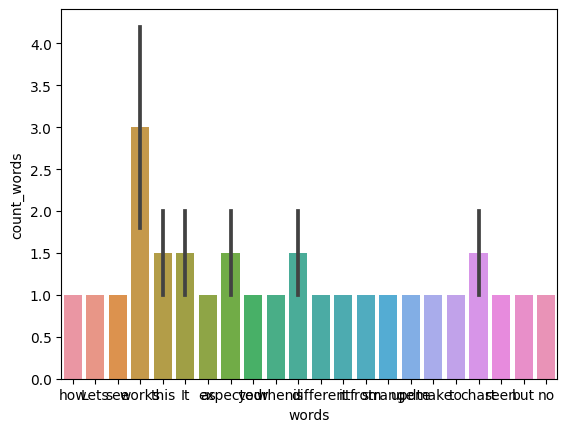

In [64]:
sns.barplot(data=chartingData,x='words',y='count_words')